# Exploring dataset

## Import datatset 

Major csv files from this competiton are train.csv, test.csv, sample_submission.csv, structures.csv. Thus, we will explore these files first.
    - train.csv: the training set
    - test.csv: the testing set
    - sample_submission.csv: a sample submission file in the correct format
    - structures.csv: molecular structure file, X Y Z
    

In [3]:
# import basic packages for ML
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
# read all the major csv files
folder_name = 'champs-scalar-coupling/'
train = pd.read_csv(folder_name + 'train.csv')
test = pd.read_csv(folder_name + 'test.csv')
sample_submission = pd.read_csv(folder_name + 'sample_submission.csv')
structures = pd.read_csv(folder_name + 'structures.csv')

Additional dataset contains the following csv files:
    - dipole_moments.csv: contains the molecular electric dipole moments
    - magnetic_shielding_tensors.csv: contains the magnetic shielding tensors for all atoms in the molecules
    - mulliken_charges.csv: contains the mulliken charges for all atoms in the molecules.
    - potential_energy.csv: contains the potential energy of the molecules
    - scalar_coupling_contributions.csv: contains four types of contributions

In [5]:
# read additional files
dipole_moments = pd.read_csv(folder_name + 'dipole_moments.csv')
mag_shield_tensors = pd.read_csv(folder_name +
                                 'magnetic_shielding_tensors.csv')
mull_charges = pd.read_csv(folder_name + 'mulliken_charges.csv')
pot_energy = pd.read_csv(folder_name + 'potential_energy.csv')
sca_cou_contri = pd.read_csv(folder_name + 'scalar_coupling_contributions.csv')

## Merge datasets

In [6]:
# drop id column in train df
train.drop('id', axis=1, inplace=True)

In [7]:
# create distance features in dipole_moments
dipole_moments['distance'] = dipole_moments['X']+dipole_moments['Y']+dipole_moments['Z']
dipole_moments['distance_mean'] = dipole_moments['distance'].apply(lambda x: x/3)

In [8]:
# merge train/test and structures with atom index
def map_atom_info(df, other_df, other_df_name, atom_idx):
    # merge train and structures
    if other_df_name == 'structures':
        df = pd.merge(df,
                      other_df,
                      how='left',
                      left_on=['molecule_name', f'atom_index_{atom_idx}'],
                      right_on=['molecule_name', 'atom_index'])
        
        df = df.drop('atom_index', axis=1)
        
        df = df.rename(
            columns={
                'atom': f'atom_{atom_idx}',
                'x': f'x_{atom_idx}',
                'y': f'y_{atom_idx}',
                'z': f'z_{atom_idx}'
            })
    # merge train and mag_shield_tensors
    elif other_df_name == 'mag_shield_tensors':
        other_df = other_df.drop(['YX', 'ZX', 'ZY'], axis=1)
        df = pd.merge(df,
                      other_df,
                      how='left',
                      left_on=['molecule_name', f'atom_index_{atom_idx}'],
                      right_on=['molecule_name', 'atom_index'])
        df.drop('atom_index', axis=1, inplace=True)
        df = df.rename(
            columns={
                'atom': f'atom_{atom_idx}',
                'XX': f'XX_{atom_idx}',
                'YY': f'YY_{atom_idx}',
                'ZZ': f'ZZ_{atom_idx}',
                'XY': f'XY_{atom_idx}',
                'YZ': f'YZ_{atom_idx}',
            })
    # merge train and mulliken_charges
    elif other_df_name == 'mull_charges':
        df = pd.merge(df,
                     other_df,
                     how='left',
                     left_on=['molecule_name', f'atom_index_{atom_idx}'],
                     right_on=['molecule_name', 'atom_index'])
        df.drop('atom_index', axis=1, inplace=True)
        df = df.rename(
            columns = {'mulliken_charge': f'mulliken_charge_{atom_idx}'}
        )
    
    else:
        print(f'{other_df} dataframe is not found')
        
    return df


In [9]:
# start merging
train = map_atom_info(train, structures, 'structures', 0)
train = map_atom_info(train, structures, 'structures', 1)
train = map_atom_info(train, mag_shield_tensors, 'mag_shield_tensors', 0)
train = map_atom_info(train, mag_shield_tensors, 'mag_shield_tensors', 1)
train = map_atom_info(train, mull_charges, 'mull_charges', 0)
train = map_atom_info(train, mull_charges, 'mull_charges', 1)

test = map_atom_info(test, structures, 'structures', 0)
test = map_atom_info(test, structures, 'structures', 1)
test = map_atom_info(test, mag_shield_tensors, 'mag_shield_tensors', 0)
test = map_atom_info(test, mag_shield_tensors, 'mag_shield_tensors', 1)
test = map_atom_info(test, mull_charges, 'mull_charges', 0)
test = map_atom_info(test, mull_charges, 'mull_charges', 1)

In [10]:
# merge train/test and structures without atom index
def merge_other_df(df, other_df, other_df_name):
    # merge train and pot_energy
    if other_df_name == 'pot_energy':
        df = pd.merge(df,
                     other_df,
                     how='left',
                     on='molecule_name')
    # merge train and dipole_moments
    elif other_df_name == 'dipole_moments':
        df = pd.merge(df,
                     other_df,
                     how='left',
                     on='molecule_name')
    else:
        print(f'{other_df} dataframe is not found')
        
    return df

In [11]:
# continue merging
train = merge_other_df(train, pot_energy, 'pot_energy')
train = merge_other_df(train, dipole_moments, 'dipole_moments')

test = merge_other_df(test, pot_energy, 'pot_energy')
test = merge_other_df(test, dipole_moments, 'dipole_moments')

# Data preprocessing

## exploring data insight

In [12]:
train.corr()['scalar_coupling_constant']

atom_index_0                0.018839
atom_index_1               -0.218989
scalar_coupling_constant    1.000000
x_0                        -0.006015
y_0                        -0.013119
z_0                         0.004807
x_1                         0.005132
y_1                         0.021189
z_1                        -0.007792
XX_0                       -0.024919
XY_0                       -0.000947
YY_0                       -0.042562
XZ_x                       -0.002161
YZ_0                        0.000404
ZZ_0                       -0.054809
XX_1                        0.223554
XY_1                        0.000740
YY_1                        0.221592
XZ_y                        0.000188
YZ_1                       -0.001670
ZZ_1                        0.237707
mulliken_charge_0          -0.025444
mulliken_charge_1          -0.360745
potential_energy           -0.017187
X                           0.000101
Y                           0.000315
Z                           0.002648
d

In [13]:
train.describe()

,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,XX_0,...,YZ_1,ZZ_1,mulliken_charge_0,mulliken_charge_1,potential_energy,X,Y,Z,distance,distance_mean
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,...,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,1.335689e+01,5.883966e+00,1.592165e+01,1.058781e-01,-2.203691e-01,4.712888e-02,9.757184e-02,-3.956294e-01,7.768257e-02,2.962281e+01,...,2.856011e-01,1.110627e+02,1.221098e-01,-4.128869e-02,-4.042052e+02,-1.881619e-02,8.021838e-02,2.280645e-01,2.894667e-01,9.648891e-02
std,3.267712e+00,4.993943e+00,3.494198e+01,1.759873e+00,2.121789e+00,1.564513e+00,1.479416e+00,1.767196e+00,1.255910e+00,3.033050e+00,...,1.766086e+01,5.816133e+01,4.474921e-02,2.402681e-01,3.715726e+01,2.123380e+00,1.613989e+00,1.015052e+00,2.826685e+00,9.422282e-01
min,0.000000e+00,0.000000e+00,-3.621860e+01,-9.234889e+00,-9.494160e+00,-9.134765e+00,-9.234889e+00,-9.254405e+00,-8.789131e+00,9.777800e+00,...,-2.660990e+02,-5.480430e+02,-3.086700e-02,-7.334500e-01,-7.146262e+02,-2.295800e+01,-9.252300e+00,-6.028500e+00,-2.337830e+01,-7.792767e+00
25%,1.100000e+01,2.000000e+00,-2.549780e-01,-9.530924e-01,-1.836966e+00,-9.642128e-01,-7.927602e-01,-1.607567e+00,-6.696343e-01,2.761585e+01,...,-4.454300e+00,5.728035e+01,9.839700e-02,-2.362810e-01,-4.244322e+02,-1.182200e+00,-8.477000e-01,-3.028000e-01,-1.447100e+00,-4.823667e-01
50%,1.300000e+01,5.000000e+00,2.281130e+00,1.341212e-01,-2.979936e-01,4.972893e-03,4.660419e-02,-5.081915e-01,1.549763e-02,2.925070e+01,...,3.000000e-04,1.272380e+02,1.135030e-01,-3.983900e-02,-4.032927e+02,-1.000000e-04,6.320000e-02,1.219000e-01,1.426000e-01,4.753333e-02
75%,1.600000e+01,8.000000e+00,7.390655e+00,1.227746e+00,1.753418e+00,1.035102e+00,9.682240e-01,2.882334e-01,8.926133e-01,3.121620e+01,...,4.814400e+00,1.534400e+02,1.287900e-01,1.186010e-01,-3.859742e+02,1.136900e+00,1.067400e+00,8.839000e-01,1.974900e+00,6.583000e-01
max,2.800000e+01,2.800000e+01,2.048800e+02,9.382240e+00,9.714469e+00,7.637578e+00,8.420893e+00,8.653665e+00,7.460225e+00,4.794440e+01,...,2.981170e+02,3.396940e+02,4.030940e-01,6.386140e-01,-4.052368e+01,2.187380e+01,1.300560e+01,6.880100e+00,2.153780e+01,7.179267e+00


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658147 entries, 0 to 4658146
Data columns (total 33 columns):
molecule_name               object
atom_index_0                int64
atom_index_1                int64
type                        object
scalar_coupling_constant    float64
atom_0                      object
x_0                         float64
y_0                         float64
z_0                         float64
atom_1                      object
x_1                         float64
y_1                         float64
z_1                         float64
XX_0                        float64
XY_0                        float64
YY_0                        float64
XZ_x                        float64
YZ_0                        float64
ZZ_0                        float64
XX_1                        float64
XY_1                        float64
YY_1                        float64
XZ_y                        float64
YZ_1                        float64
ZZ_1                        flo

In [15]:
train.type.value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

In [16]:
train.atom_0.value_counts()

H    4658147
Name: atom_0, dtype: int64

In [17]:
train.atom_1.value_counts()

C    3360469
H     968647
N     329031
Name: atom_1, dtype: int64

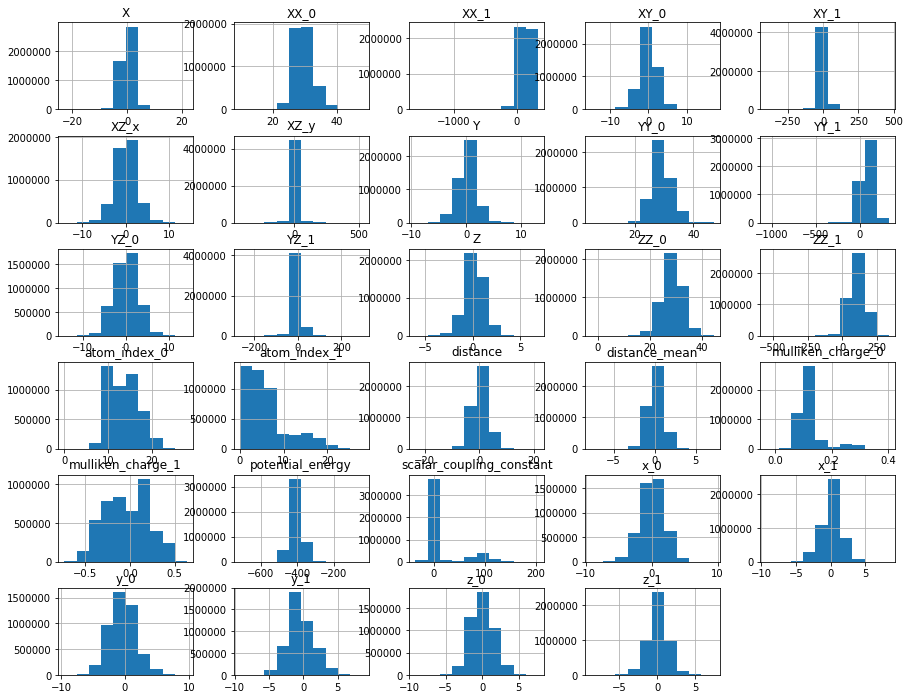

In [18]:
train.hist(figsize=(15,12))
plt.show()

## Reduce memory usage helper function

In [19]:
# a helper method that reduce the memory usage of dataframe
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) /
                                        start_mem))

    return df

## feature engineering

In [20]:
# create distance feature
def extract_features(df):

    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values

    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1'])**2
    df['dist_y'] = (df['y_0'] - df['y_1'])**2
    df['dist_z'] = (df['z_0'] - df['z_1'])**2

    df = reduce_mem_usage(df)
    return df

In [21]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

In [ ]:
'''
# brute force feature engineering
# create all other features such as mean, std, diff, max, min, etc.
def create_features(df):
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')

    df = reduce_mem_usage(df)
    return df
'''

## Feature Transformation pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# distinguish numerical columns and categorical columns
num_cols = ['atom_index_0', 'atom_index_1', 'x_0', 'y_0', 'z_0', 'XX_0', 'XY_0', 'YY_0',
           'XZ_x', 'YZ_0', 'ZZ_0', 'XX_1', 'XY_1', 'YY_1', 'XZ_y', 'YZ_1', 'ZZ_1',
           'mulliken_charge_0', 'mulliken_charge_1', 'potential_energy', 'X', 'Y', 'Z',
           'distance', 'distance_mean', 'dist', 'dist_x', 'dist_y', 'dist_z']
cat_cols = ['type', 'atom_0', 'atom_1', 'type_0']
feature_cols = num_cols+cat_cols

In [ ]:
'''
# more numerical features
more_features = [
    'molecule_dist_mean', 'molecule_dist_min', 'molecule_dist_max',
    'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff',
    'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
    'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_mean_diff',
    'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div', 'molecule_atom_index_1_dist_mean',
    'molecule_atom_index_1_dist_max', 'molecule_atom_index_1_dist_min',
    'molecule_atom_1_dist_mean', 'molecule_atom_1_dist_min',
    'molecule_type_dist_mean', 'molecule_type_dist_max',
    'molecule_type_dist_min'
]
# extend these features into the original feature list
more_num_cols = num_cols.extend(more_features)
'''

In [24]:
# utilize ColumnTransformer to create a feature transformation pipeline

# for numerical data, we use standardization to generalize the spread
# for categorical data, we use OneHotEncoder to transform them 
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols),
])


## set up train_set and test_set

In [25]:
# create more features in train and test sets
train_set = extract_features(train)
test_set = extract_features(test)

Memory usage of dataframe is 1386.01 MB
Memory usage after optimization is: 358.54 MB
Decreased by 74.1%
Memory usage of dataframe is 745.51 MB
Memory usage after optimization is: 484.27 MB
Decreased by 35.0%


In [28]:
# create X and y for both train_set and test_set
X_train = train[feature_cols].copy()
y_train = train['scalar_coupling_constant'].copy()
X_test = test[feature_cols].copy()


In [30]:
# fit and transform X matrix
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

/Users/kailing/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/kailing/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [32]:
# creating a sample set 
# so we can try to train models in a shourt amount of timea
train_sample = train_set.sample(n=1000, random_state=42)

X_train_sample = train_sample[feature_cols].copy()
y_train_sample = train_sample['scalar_coupling_constant'].copy()

X_train_sample_prepared = full_pipeline.fit_transform(X_train_sample)

# Model Training

## Import regression models

In [38]:
# import all models I will use for regression
from sklearn.linear_model import (Ridge, Lasso, SGDRegressor)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
import lightgbm as lgb
from xgboost import XGBRegressor

# add neural network regressor

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RandomSearchCV

/Users/kailing/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Train model with randomSearchCV

In [39]:
# Scoring: Log of MAE
from sklearn.metrics import (mean_absolute_error, make_scorer)

def log_mae(y_true, y_pred):
    return np.log(mean_absolute_error(y_true, y_pred))

score = make_scorer(log_mae, greater_is_better=False)

### Ridge model

In [ ]:
ridge_reg = Ridge()
ridge_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = ridge_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

### Lasso model

In [ ]:
lasso_reg = Lasso()
lasso_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = lasso_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

### SGDRegressor model

In [ ]:
sdg_reg = SGDRegressor()
sdg_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = sdg_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

### Random Forest Rregressor model

In [41]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, y_train)

/Users/kailing/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
y_pred_train = forest_reg.predict(X_train_prepared)

In [43]:
log_mae(y_train, y_pred_train)

0.18283521593279795

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(0.1, 1, num=10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(0.1, 0.5, num=5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, 
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)

### Gradient Boosting Regressor model

In [ ]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = gb_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

### LGB Regreesor model

In [ ]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = lgb_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

#### Bayesian Optimization on LGB regressor

In [44]:
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_prepared,
                                                              y_train,
                                                              test_size=0.2,
                                                              random_state=128)

In [40]:
paramsLGB = {
    'learning_rate': (0.001,0.1),
    'num_leaves': (32,256),
    'min_child_samples': (15,100),
    'min_data_in_leaf': (10, 90),
    'bagging_freq' : (5,90),
    'max_depth': (-1,9),
    'subsample_freq': (1,9),
    'subsample': (0.001,0.9),
    'bagging_seed': (10,50),
    'reg_alpha': (0.001,0.1),
    'reg_lambda': (0.001,0.3),
    'colsample_bytree': (1.0,9.0)
    
}

In [46]:
def LGB_bayesian(bagging_freq, learning_rate, num_leaves, min_child_samples,
                 min_data_in_leaf, max_depth, subsample_freq, subsample,
                 bagging_seed, reg_alpha, reg_lambda, colsample_bytree):

    # LightGBM expects next three parameters need to be integer.
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    min_data_in_leaf = int(min_data_in_leaf)
    bagging_freq = int(bagging_freq)
    Random_Seed = 4520
    assert type(num_leaves) == int
    assert type(max_depth) == int
    assert type(min_data_in_leaf) == int
    assert type(bagging_freq) == int

    param = {
        'bagging_freq': bagging_freq,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_child_samples': min_child_samples,
        'min_data_in_leaf': min_data_in_leaf,
        'max_depth': max_depth,
        'subsample_freq': subsample_freq,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'seed': Random_Seed,
        'feature_fraction_seed': Random_Seed,
        'bagging_seed': Random_Seed,
        'drop_seed': Random_Seed,
        'data_random_seed': Random_Seed,
        'boosting_type': 'gbdt',
        'is_unbalance': False,
        'boost_from_average': True,
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_fraction': 1
    }
    model = lgb.LGBMRegressor(**param, n_estimators=10000, n_jobs=-1)
    model.fit(X_train_split,
              y_train_split,
              eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
              eval_metric='mae',
              verbose=100, 
              early_stopping_rounds=200)

    y_pred = model.predict(X_val_split)
    score = log_mae(y_val_split, y_pred)

    return score

In [47]:
LGB_BO = BayesianOptimization(LGB_bayesian, paramsLGB, random_state=42)

In [ ]:
LGB_BO.maximize(init_points=10, n_iter=15, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | baggin... | baggin... | colsam... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.67809	valid_1's l1: 1.68569
[200]	training's l1: 1.60391	valid_1's l1: 1.61705
[300]	training's l1: 1.57056	valid_1's l1: 1.58916
[400]	training's l1: 1.55709	valid_1's l1: 1.58065
[500]	training's l1: 1.5448	valid_1's l1: 1.57293
[600]	training's l1: 1.53621	valid_1's l1: 1.56923
[700]	training's l1: 1.53095	valid_1's l1: 1.56859
[800]	training's l1: 1.52569	valid_1's l1: 1.56768
[900]	training's l1: 1.52103	valid_1's l1: 1.56756
[1000]	training's l1: 1.51767	valid_1's l1: 1.56843
Early stopping, best iteration is:
[830]	training's l1: 1.52364	valid_1's l1: 1.56693
|

[2500]	training's l1: 1.64126	valid_1's l1: 1.64673
[2600]	training's l1: 1.63641	valid_1's l1: 1.64207
[2700]	training's l1: 1.63072	valid_1's l1: 1.63657
[2800]	training's l1: 1.62492	valid_1's l1: 1.63098
[2900]	training's l1: 1.62029	valid_1's l1: 1.62649
[3000]	training's l1: 1.61498	valid_1's l1: 1.62132
[3100]	training's l1: 1.60971	valid_1's l1: 1.61628
[3200]	training's l1: 1.60484	valid_1's l1: 1.61154
[3300]	training's l1: 1.60044	valid_1's l1: 1.60736
[3400]	training's l1: 1.59664	valid_1's l1: 1.60374
[3500]	training's l1: 1.59261	valid_1's l1: 1.59986
[3600]	training's l1: 1.58817	valid_1's l1: 1.59561
[3700]	training's l1: 1.58499	valid_1's l1: 1.59254
[3800]	training's l1: 1.5814	valid_1's l1: 1.58912
[3900]	training's l1: 1.57689	valid_1's l1: 1.58475
[4000]	training's l1: 1.57333	valid_1's l1: 1.58136
[4100]	training's l1: 1.56936	valid_1's l1: 1.57751
[4200]	training's l1: 1.56563	valid_1's l1: 1.57391
[4300]	training's l1: 1.56127	valid_1's l1: 1.5697
[4400]	trainin

[7500]	training's l1: 0.86322	valid_1's l1: 1.08842
[7600]	training's l1: 0.859928	valid_1's l1: 1.08719
[7700]	training's l1: 0.856588	valid_1's l1: 1.08595
[7800]	training's l1: 0.853134	valid_1's l1: 1.08459
[7900]	training's l1: 0.849749	valid_1's l1: 1.08332
[8000]	training's l1: 0.846359	valid_1's l1: 1.08195
[8100]	training's l1: 0.843248	valid_1's l1: 1.08076
[8200]	training's l1: 0.840044	valid_1's l1: 1.07956
[8300]	training's l1: 0.83703	valid_1's l1: 1.07851
[8400]	training's l1: 0.833592	valid_1's l1: 1.07714
[8500]	training's l1: 0.830477	valid_1's l1: 1.07602
[8600]	training's l1: 0.827515	valid_1's l1: 1.07496
[8700]	training's l1: 0.824785	valid_1's l1: 1.07426
[8800]	training's l1: 0.821995	valid_1's l1: 1.07342
[8900]	training's l1: 0.818835	valid_1's l1: 1.07232
[9000]	training's l1: 0.815746	valid_1's l1: 1.07117
[9100]	training's l1: 0.813058	valid_1's l1: 1.07039
[9200]	training's l1: 0.810341	valid_1's l1: 1.06954
[9300]	training's l1: 0.807664	valid_1's l1: 1.0

[8800]	training's l1: 2.73109	valid_1's l1: 2.73146
[8900]	training's l1: 2.73004	valid_1's l1: 2.73041
[9000]	training's l1: 2.72887	valid_1's l1: 2.72922
[9100]	training's l1: 2.72777	valid_1's l1: 2.72813
[9200]	training's l1: 2.72692	valid_1's l1: 2.72728
[9300]	training's l1: 2.72579	valid_1's l1: 2.72616
[9400]	training's l1: 2.7249	valid_1's l1: 2.72527
[9500]	training's l1: 2.72385	valid_1's l1: 2.72422
[9600]	training's l1: 2.72278	valid_1's l1: 2.72316
[9700]	training's l1: 2.72192	valid_1's l1: 2.72229
[9800]	training's l1: 2.72108	valid_1's l1: 2.72145
[9900]	training's l1: 2.72045	valid_1's l1: 2.72082
[10000]	training's l1: 2.71941	valid_1's l1: 2.71977
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 2.71941	valid_1's l1: 2.71977
|  6        |  1.001    |  38.04    |  20.85    |  7.63     |  0.03632  |  1.809    |  61.13    |  21.27    |  211.7    |  0.008381 |  0.2961   |  0.6952   |  2.59     |
Training until validation scores don't improve for 20

[2900]	training's l1: 1.19241	valid_1's l1: 1.25298
[3000]	training's l1: 1.18618	valid_1's l1: 1.24843
[3100]	training's l1: 1.1808	valid_1's l1: 1.24458
[3200]	training's l1: 1.17543	valid_1's l1: 1.2408
[3300]	training's l1: 1.17049	valid_1's l1: 1.23739
[3400]	training's l1: 1.16486	valid_1's l1: 1.23351
[3500]	training's l1: 1.16025	valid_1's l1: 1.23054
[3600]	training's l1: 1.15578	valid_1's l1: 1.22773
[3700]	training's l1: 1.15123	valid_1's l1: 1.2248
[3800]	training's l1: 1.14603	valid_1's l1: 1.22121
[3900]	training's l1: 1.14107	valid_1's l1: 1.21791
[4000]	training's l1: 1.13668	valid_1's l1: 1.21518
[4100]	training's l1: 1.13245	valid_1's l1: 1.21254
[4200]	training's l1: 1.12827	valid_1's l1: 1.20993
[4300]	training's l1: 1.12403	valid_1's l1: 1.20725
[4400]	training's l1: 1.11994	valid_1's l1: 1.20473
[4500]	training's l1: 1.11592	valid_1's l1: 1.20222
[4600]	training's l1: 1.11132	valid_1's l1: 1.19916
[4700]	training's l1: 1.10757	valid_1's l1: 1.19685
[4800]	training

[7900]	training's l1: 1.20313	valid_1's l1: 1.25946
[8000]	training's l1: 1.20005	valid_1's l1: 1.25689
[8100]	training's l1: 1.19754	valid_1's l1: 1.25497
[8200]	training's l1: 1.19556	valid_1's l1: 1.25356
[8300]	training's l1: 1.19331	valid_1's l1: 1.25187
[8400]	training's l1: 1.19161	valid_1's l1: 1.25068
[8500]	training's l1: 1.1892	valid_1's l1: 1.24883
[8600]	training's l1: 1.18732	valid_1's l1: 1.24755
[8700]	training's l1: 1.18497	valid_1's l1: 1.24579
[8800]	training's l1: 1.18253	valid_1's l1: 1.2439
[8900]	training's l1: 1.18022	valid_1's l1: 1.24219
[9000]	training's l1: 1.17743	valid_1's l1: 1.23988
[9100]	training's l1: 1.17585	valid_1's l1: 1.23887
[9200]	training's l1: 1.17335	valid_1's l1: 1.23689
[9300]	training's l1: 1.17094	valid_1's l1: 1.23508
[9400]	training's l1: 1.16894	valid_1's l1: 1.23368
[9500]	training's l1: 1.16683	valid_1's l1: 1.23209
[9600]	training's l1: 1.16514	valid_1's l1: 1.23094
[9700]	training's l1: 1.16345	valid_1's l1: 1.2298
[9800]	training

[2100]	training's l1: 1.81175	valid_1's l1: 1.81424
[2200]	training's l1: 1.80378	valid_1's l1: 1.80642
[2300]	training's l1: 1.79881	valid_1's l1: 1.80158
[2400]	training's l1: 1.79421	valid_1's l1: 1.79719
[2500]	training's l1: 1.78738	valid_1's l1: 1.79056
[2600]	training's l1: 1.78264	valid_1's l1: 1.78605
[2700]	training's l1: 1.77789	valid_1's l1: 1.7815
[2800]	training's l1: 1.77379	valid_1's l1: 1.77768
[2900]	training's l1: 1.77103	valid_1's l1: 1.77501
[3000]	training's l1: 1.76879	valid_1's l1: 1.77295
[3100]	training's l1: 1.76659	valid_1's l1: 1.77098
[3200]	training's l1: 1.76108	valid_1's l1: 1.76551
[3300]	training's l1: 1.75689	valid_1's l1: 1.76147
[3400]	training's l1: 1.75605	valid_1's l1: 1.76093
[3500]	training's l1: 1.75354	valid_1's l1: 1.75857
[3600]	training's l1: 1.75102	valid_1's l1: 1.75606
[3700]	training's l1: 1.74977	valid_1's l1: 1.75499
[3800]	training's l1: 1.74655	valid_1's l1: 1.75178
[3900]	training's l1: 1.74325	valid_1's l1: 1.74853
[4000]	traini

[7100]	training's l1: 1.55336	valid_1's l1: 1.56417
[7200]	training's l1: 1.55193	valid_1's l1: 1.56288
[7300]	training's l1: 1.55042	valid_1's l1: 1.56151
[7400]	training's l1: 1.5488	valid_1's l1: 1.56005
[7500]	training's l1: 1.54723	valid_1's l1: 1.55863
[7600]	training's l1: 1.54592	valid_1's l1: 1.55748
[7700]	training's l1: 1.54374	valid_1's l1: 1.55542
[7800]	training's l1: 1.54143	valid_1's l1: 1.55324
[7900]	training's l1: 1.53899	valid_1's l1: 1.55091
[8000]	training's l1: 1.53608	valid_1's l1: 1.54811
[8100]	training's l1: 1.53336	valid_1's l1: 1.54549
[8200]	training's l1: 1.53019	valid_1's l1: 1.54242
[8300]	training's l1: 1.52768	valid_1's l1: 1.53998
[8400]	training's l1: 1.52504	valid_1's l1: 1.53744
[8500]	training's l1: 1.52257	valid_1's l1: 1.53509
[8600]	training's l1: 1.52002	valid_1's l1: 1.53261
[8700]	training's l1: 1.51795	valid_1's l1: 1.53063
[8800]	training's l1: 1.51554	valid_1's l1: 1.52833
[8900]	training's l1: 1.51334	valid_1's l1: 1.5262
[9000]	trainin

[1300]	training's l1: 7.01482	valid_1's l1: 7.01005
[1400]	training's l1: 6.41994	valid_1's l1: 6.41611
[1500]	training's l1: 5.88924	valid_1's l1: 5.88632
[1600]	training's l1: 5.41597	valid_1's l1: 5.41387
[1700]	training's l1: 4.99386	valid_1's l1: 4.99249
[1800]	training's l1: 4.6177	valid_1's l1: 4.61693
[1900]	training's l1: 4.28277	valid_1's l1: 4.28259
[2000]	training's l1: 3.98527	valid_1's l1: 3.98549
[2100]	training's l1: 3.72174	valid_1's l1: 3.72227
[2200]	training's l1: 3.48668	valid_1's l1: 3.48751
[2300]	training's l1: 3.2792	valid_1's l1: 3.28031
[2400]	training's l1: 3.09553	valid_1's l1: 3.09692
[2500]	training's l1: 2.93452	valid_1's l1: 2.93622
[2600]	training's l1: 2.79206	valid_1's l1: 2.79393
[2700]	training's l1: 2.66822	valid_1's l1: 2.67022
[2800]	training's l1: 2.55855	valid_1's l1: 2.56067
[2900]	training's l1: 2.4631	valid_1's l1: 2.46543
[3000]	training's l1: 2.37985	valid_1's l1: 2.38238
[3100]	training's l1: 2.30823	valid_1's l1: 2.31095
[3200]	training

[6300]	training's l1: 1.56383	valid_1's l1: 1.57363
[6400]	training's l1: 1.56164	valid_1's l1: 1.5716
[6500]	training's l1: 1.55968	valid_1's l1: 1.5698
[6600]	training's l1: 1.55738	valid_1's l1: 1.56764
[6700]	training's l1: 1.55523	valid_1's l1: 1.5656
[6800]	training's l1: 1.55367	valid_1's l1: 1.5642
[6900]	training's l1: 1.55191	valid_1's l1: 1.56258
[7000]	training's l1: 1.55026	valid_1's l1: 1.56108
[7100]	training's l1: 1.54869	valid_1's l1: 1.55965
[7200]	training's l1: 1.54723	valid_1's l1: 1.55832
[7300]	training's l1: 1.5455	valid_1's l1: 1.55672
[7400]	training's l1: 1.54401	valid_1's l1: 1.55537
[7500]	training's l1: 1.54222	valid_1's l1: 1.55373
[7600]	training's l1: 1.54081	valid_1's l1: 1.55248
[7700]	training's l1: 1.5394	valid_1's l1: 1.55123
[7800]	training's l1: 1.53719	valid_1's l1: 1.54915
[7900]	training's l1: 1.53445	valid_1's l1: 1.54655
[8000]	training's l1: 1.53153	valid_1's l1: 1.54376
[8100]	training's l1: 1.52876	valid_1's l1: 1.54112
[8200]	training's 

### XGB Regressor model

In [ ]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_prepared, y_train)

In [ ]:
y_pred_train = xgb_reg.predict(X_train_prepared)

In [ ]:
log_mae(y_train, y_pred_train)

## Model selection

# Model Evaluation

# Submission